In [1]:
%%capture
! pip install gym gym[box2d]
! pip install ipywidgets

In [6]:
%%capture
# simple neural network implementation of qlearning
import gym
import pickle
import random

import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt

from tensorflow.keras import layers, optimizers
from IPython.display import HTML, display
from PIL import Image

# RL using OpenAI Gym: https://www.learndatasci.com/tutorials/reinforcement-q-learning-scratch-python-openai-gym/
# Deep Q-Learning: https://github.com/adventuresinML/adventures-in-ml-code/blob/master/r_learning_tensorflow.py

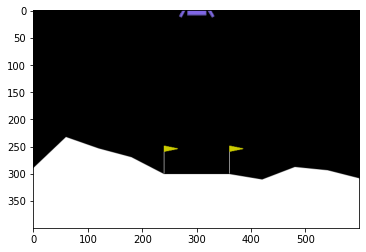

In [4]:
seed = 111

tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

"""
Observation Space has 8 states
===============================

1- The coordinates of the lander in x & y.
2- Its linear velocities in x & y.
3- Its angle.
4- Its angular velocity.
5- Two booleans that represent whether each leg is in contact with the ground or not.

Action Space has 4 discrete actions
===================================
1- Do nothing.
2- Fire left orientation engine.
3- Fire main engine.
4- Fire right orientation engine.

"""

env = gym.make("LunarLander-v2")
obs = env.reset()
image = env.render(mode='rgb_array')

plt.imshow(image)

## Utility Methods to Save Output as GIF

In [7]:
def save_visuals(env, frames):
    # Save the current game visuals
    frame = env.render(mode='rgb_array')
    frames.append(frame)

def save_frames_as_gif(container, episode_id, frames):
    gif = Image.fromarray(np.copy(frames[0]))
       
    gif_name = 'lunar_lander.{}.{}.gif'.format(episode_id, random.randint(0,2e9))

    gif.save(
        gif_name,
        append_images=list(map(lambda im: Image.fromarray(im), frames[1:])),
        save_all=True, duration=5, loop=0
    )

    container[episode_id] = gif_name

## Create Model

In [17]:
N_STATES = env.observation_space.shape[0]
N_ACTIONS = env.action_space.n

def create_model():
    """Construct the critic network with q-values per action as output"""
    model = keras.Sequential([
        layers.Input(shape=(image.shape)),
        layers.Conv2D(32, 5, activation="relu", use_bias=False),
        layers.Conv2D(32, 5, activation="relu", use_bias=False),
        layers.Conv2D(64, 5, activation="relu", use_bias=False),
        layers.MaxPool2D(2),
        layers.Conv2D(64, 3, activation="relu", use_bias=False),
        layers.Dense(512, activation="relu"),
        layers.Flatten(),
        layers.Dense(N_ACTIONS, activation='linear')
    ])
    
    model.compile(optimizer=optimizers.Adam(.001), loss='mse')

    return model

model = create_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 396, 596, 32)      2400      
                                                                 
 conv2d_9 (Conv2D)           (None, 392, 592, 32)      25600     
                                                                 
 conv2d_10 (Conv2D)          (None, 388, 588, 64)      51200     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 194, 294, 64)     0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 192, 292, 64)      36864     
                                                                 
 dense_4 (Dense)             (None, 192, 292, 512)     33280     
                                                      

## Training

In [19]:
GAMMA = 0.95
EXPLORATION_RATE = 0.5

def choose_action(model, state):
    random_action = lambda: np.random.randint(N_ACTIONS)
    
    def predicted_action():
        q_values = model(tf.expand_dims(state, 0))
        action = tf.squeeze(tf.argmax(q_values, axis=-1))
        return action.numpy()

    # Choose between the greey move or the random move.
    # Greedy move take the greedy approach to chose the best current action.
    epsilon = np.random.rand()
    action =  random_action() if epsilon <= EXPLORATION_RATE else predicted_action()

    return action

def obs_to_state(obs):
    state = np.squeeze(obs)
    return state

def play(model, state):
    return choose_action(model, state)

def capped_append(memory, data, max_size=1000):
    memory.append(data)
    if len(memory) > max_size: memory.pop(0)

def normalize_reward(reward, min=-150.0, max=150.0):
    return (reward-min)/(max-min)

def update_exploration_rate(step_id):
    global EXPLORATION_RATE
    if step_id > 1000: EXPLORATION_RATE = .01
    elif step_id > 500: EXPLORATION_RATE = .05
    elif step_id > 300: EXPLORATION_RATE = .1
    elif step_id > 100: EXPLORATION_RATE = .2
    elif step_id > 50: EXPLORATION_RATE = .3
    else: EXPLORATION_RATE = .5

def batch_train(step_id, model, memory, score, bs=16, log=False):
    update_exploration_rate(step_id)
    batch = random.sample(memory, bs) if len(memory) > bs else memory

    X = tf.stack([m[0] for m in batch])
    next_X = tf.stack([m[3] for m in batch])

    q_s_a = model.predict(X)
    q_s_a_next = model.predict(next_X)

    for idx, (_, action, reward, _, done) in enumerate(batch):
        if done:
            q_s_a[idx][action] = reward
        else:
            q_s_a[idx][action] = reward + GAMMA*np.amax(q_s_a_next[idx])
    
    history = model.fit(tf.stack(X), q_s_a, batch_size=bs, epochs=1, verbose=0)

    if log and step_id%4 == 0:
        print('Step: ', step_id, 'Loss: ', history.history['loss'][-1], ' Score: ', score)
    
episodes = 3
memory = []
last_step_memory = []
sims = {}
results = []

# Reset the environment to start training from scratch.
obs = env.reset()

for episode_id in range(episodes):
    images = []
    score = 0

    for step_id in range(1000):
        # state = obs_to_state(obs)
        state = env.render(mode='rgb_array')
        action = play(model, state)
        obs, reward, done, _ = env.step(action)
        score += reward
        next_state = env.render(mode='rgb_array')

        # Save event data to memory for training later
        # capped_append(memory, (state, action, reward, obs_to_state(obs), done))
        capped_append(memory, (state, action, reward, next_state, done))
        
        # Save the current game visuals
        save_visuals(env, images)

        # Train model based on the memory
        if step_id%20 == 0: batch_train(step_id, model, memory, score)

        if done:
            episode_results = (step_id, score, reward, True if reward == 100 else False)
            results.append(episode_results)
            print('Episode:', episode_id, episode_results)
            break

    obs = env.reset()
    save_frames_as_gif(sims, episode_id, images)

with open('lunar_lander.results.pkl', 'wb') as f:
    pickle.dump(results, f)

model.save_weights('lunar_lander.h5')

2022-06-22 14:28:53.015886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 